In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

In [2]:
symmetrizeQ=True

path='/capstor/store/cscs/userlab/s1174/lyan/code/glwc2/project2/03_NpiScatteringWilson/dataPrepare/A15/data_aux/cfgs_run'
with open(path,'r') as f:
    cfgs=f.read().splitlines()
    
data={'a':[],'hybrid':[]}
for cfg in cfgs:
    print(cfg,end='         \r')
    path=f'/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15_hybrid_oldQuda/data_post/{cfg}/P.h5_0mom'
    with h5py.File(path) as f:
        t=np.mean([f[f'data/{st}/a_a'][:,0] for st in f['data'].keys()],axis=0)
        data['a'].append(t)
        tppa=np.mean([f[f'data/{st}/p+a_p+a'][:,0] for st in f['data'].keys()],axis=0)
        tpma=np.mean([f[f'data/{st}/p-a_p-a'][:,0] for st in f['data'].keys()],axis=0)
        t=np.concatenate([tppa,tpma])/4
        data['hybrid'].append(t)        
for ky in data.keys():
    t=np.array(data[ky])
    if symmetrizeQ:
        t=(t+np.roll(np.flip(t,axis=1),1,axis=1))/2
    data[ky]=t
    print(data[ky].shape,ky)

(211, 48) a   
(211, 96) hybrid


In [105]:
path='dataPrepare/A15/data_aux/cfgs_MGWorkingCPU'
with open(path) as f:
    t=f.read().splitlines()
    t=[cfg[:4] for cfg in t]
    cfgs_temp=[cfg[1:] for cfg in cfgs]
    inds_MGWorkingCPU=np.array([cfgs_temp.index(cfg) for cfg in t if cfg in cfgs_temp])

In [3]:
path='/capstor/store/cscs/userlab/s1174/lyan/code/temp/pion_A15_20240426.txt'
with open(path) as f:
    t=f.read().splitlines()
    t=[complex(ele) for ele in t]
    t=-np.reshape(t,[4,208,48])[0]
    if symmetrizeQ:
      t=t+np.roll(np.flip(t,axis=1),1,axis=1)
    data['CPU']=t[:,:24]

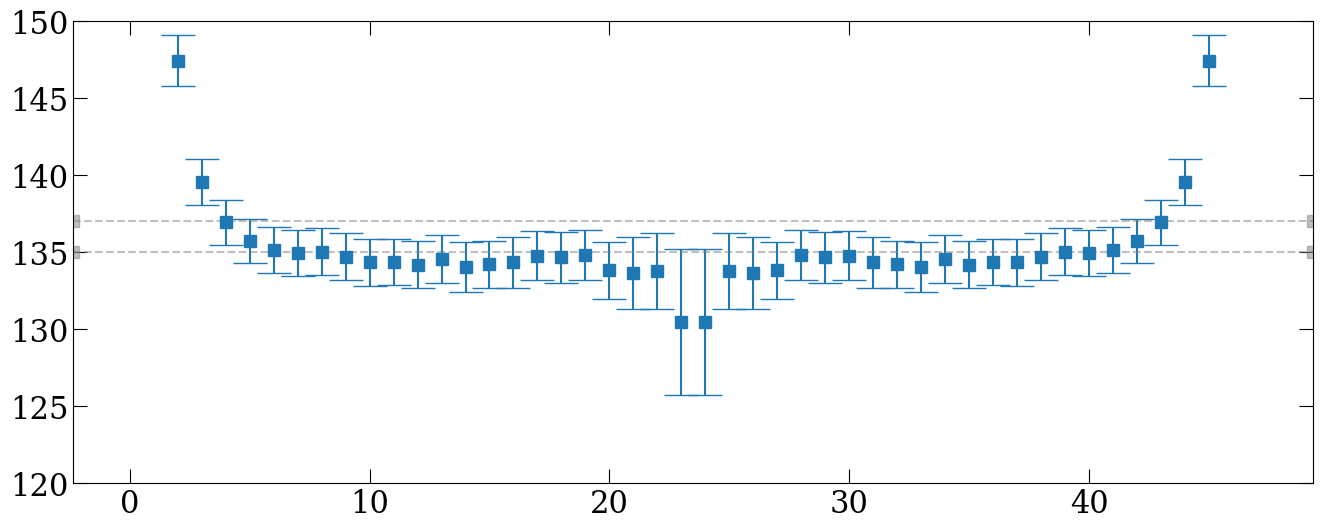

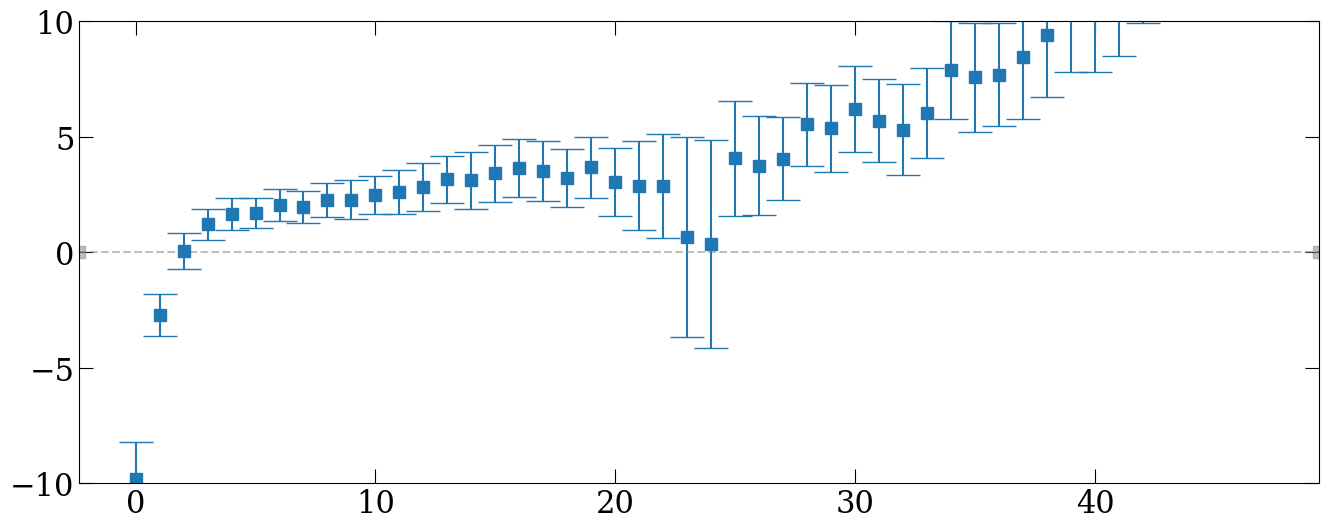

In [17]:
a=0.1163
hbarc = 1/197.327
aInv=1/(a*hbarc)

d_jk=1

inds=[i for i in range(len(cfgs)) if i not in []]
inds=[i for i in range(len(cfgs)) if i not in [82,119,209]]
# inds=inds_MGWorkingCPU
# inds=[i for i in range(len(cfgs)) if i not in [82,88,105,119,143,145,150,179,200,209]]

# fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
# ax=axs[0,0]
# xunit=1; yunit=1
# for ky in ['a','hybrid','CPU']:
#     c2pt=yu.jackknife(np.real(data[ky])[inds],d=d_jk) if ky not in ['CPU'] else yu.jackknife(np.real(data[ky]),d=d_jk)
#     mean,err=yu.jackme(c2pt)
    
#     plt_x=np.arange(len(mean))*xunit; plt_y=mean*yunit; plt_err=err*yunit
#     ax.errorbar(plt_x,plt_y,plt_err)
    
tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
    
fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
ax=axs[0,0]
xunit=1; yunit=aInv
# ax.set_ylim([100,200])
for ky in ['a','hybrid','CPU'][:1]:
    c2pt=yu.jackknife(np.real(data[ky])[inds],d=d_jk) if ky not in ['CPU'] else yu.jackknife(np.real(data[ky]),d=d_jk)
    if ky=='a':
        func=lambda c2pt:C2pt2meff(c2pt,48)
    else:
        func=lambda c2pt:C2pt2meff(c2pt,96)
    # func=lambda c2pt:np.log(c2pt/np.roll(c2pt,-1,axis=0))
    meff=yu.jackmap(func,c2pt)
    mean,err=yu.jackme(meff)
    # print(mean[:4],err[:4])
    
    plt_x=np.arange(len(mean))*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err)
ax.axhline(137,color='grey',alpha=0.5,ls='--')
ax.axhline(135,color='grey',alpha=0.5,ls='--')
# ax.axhline(130,color='grey',alpha=0.5,ls='--')
# ax.set_xlim([0,48])
ax.set_ylim([120,150])

fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
ax=axs[0,0]
xunit=1; yunit=aInv
ax.set_ylim([-10,10])
meff_a=yu.jackmap(lambda c2pt:C2pt2meff(c2pt,48),yu.jackknife(np.real(data['a'])[inds],d=d_jk))
meff_h=yu.jackmap(lambda c2pt:C2pt2meff(c2pt,96),yu.jackknife(np.real(data['hybrid'])[inds],d=d_jk))[:,:48]
meff=meff_a-meff_h

mean,err=yu.jackme(meff)
plt_x=np.arange(len(mean))*xunit; plt_y=mean*yunit; plt_err=err*yunit
ax.errorbar(plt_x,plt_y,plt_err)
ax.axhline(0,color='grey',alpha=0.5,ls='--')

In [8]:
path=f'/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15/data_post/b0120/P.h5_0mom'
with h5py.File(path) as f:
    print(f['data'].keys())
    t=f['data/st000/a_a'][:]
    print(t[1])
    t=f['data/st043/p+a_p+a'][:]/4
    print(t[1])
    t=f['data/st043/p-a_p-a'][:]/4
    print(t[1])

<KeysViewHDF5 ['st000', 'st001', 'st002', 'st003', 'st004', 'st005', 'st006', 'st007', 'st008', 'st009', 'st010', 'st011', 'st012', 'st013', 'st014', 'st015', 'st016', 'st017', 'st018', 'st019', 'st020', 'st021', 'st022', 'st023', 'st024', 'st025', 'st026', 'st027', 'st028', 'st029', 'st030', 'st031', 'st032', 'st033', 'st034', 'st035', 'st036', 'st037', 'st038', 'st039', 'st040', 'st041', 'st042', 'st043', 'st044', 'st045', 'st046', 'st047']>
[743.9899+3.8222994e-09j]
[61677.92-7.952379e-08j]
[68363.945-1.3329905e-06j]


In [ ]:
fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
ax=axs[0,0]
xunit=1; yunit=1
for ind,color in zip([82,119],['r','g']):
    for ky in ['a','hybrid']:
        c2pt=np.real(data[ky])[ind]
        
        plt_x=np.arange(len(c2pt))*xunit; plt_y=c2pt*yunit; plt_err=c2pt*yunit*0
        ax.errorbar(plt_x,plt_y,plt_err,color=color,label=cfgs[ind] if ky=='hybrid' else None)
ax.legend()

array(['a0083', 'b0120'], dtype='<U5')

8 a0009
57 a0058
88 a0089
119 b0120
143 b0144
145 b0146
150 b0151
200 b0202
209 b0212
8 a0009
57 a0058
82 a0083
88 a0089
105 a0106
119 b0120
143 b0144
150 b0151
179 b0181


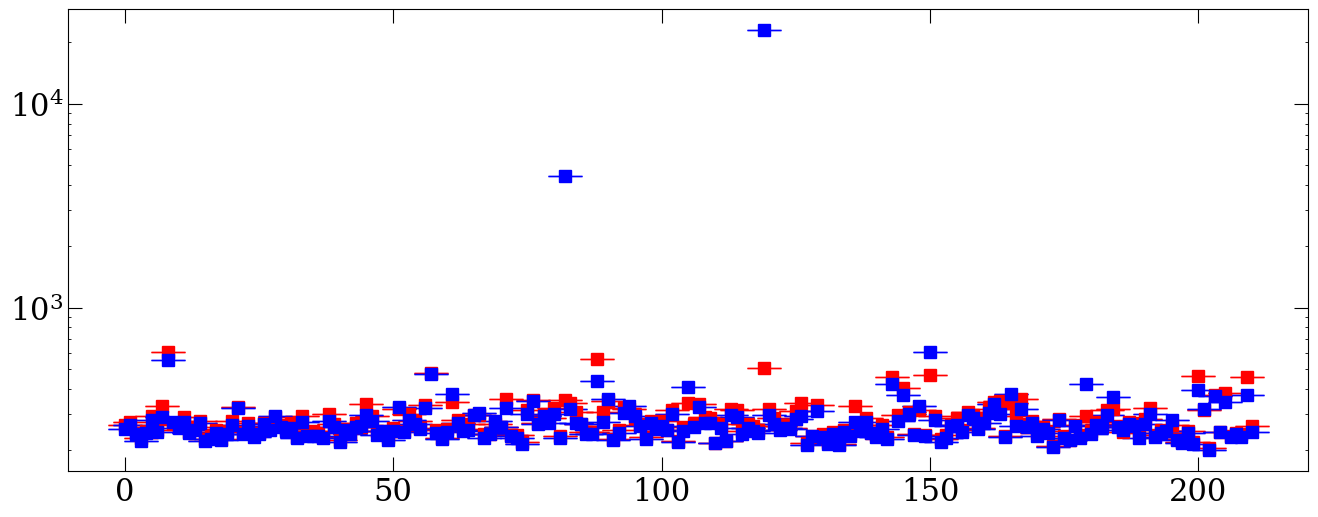

In [14]:
fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
ax=axs[0,0]
xunit=1; yunit=1
for ky in ['a','hybrid']:
    c2pt=np.real(data[ky])[:,1]
    for i,c in enumerate(c2pt):
        if c>400:
            print(i,cfgs[i])
    
    plt_x=np.arange(len(c2pt))*xunit; plt_y=c2pt*yunit; plt_err=c2pt*yunit*0
    ax.errorbar(plt_x,plt_y,plt_err,color='r' if ky=='a' else 'b')
ax.set_yscale('log')

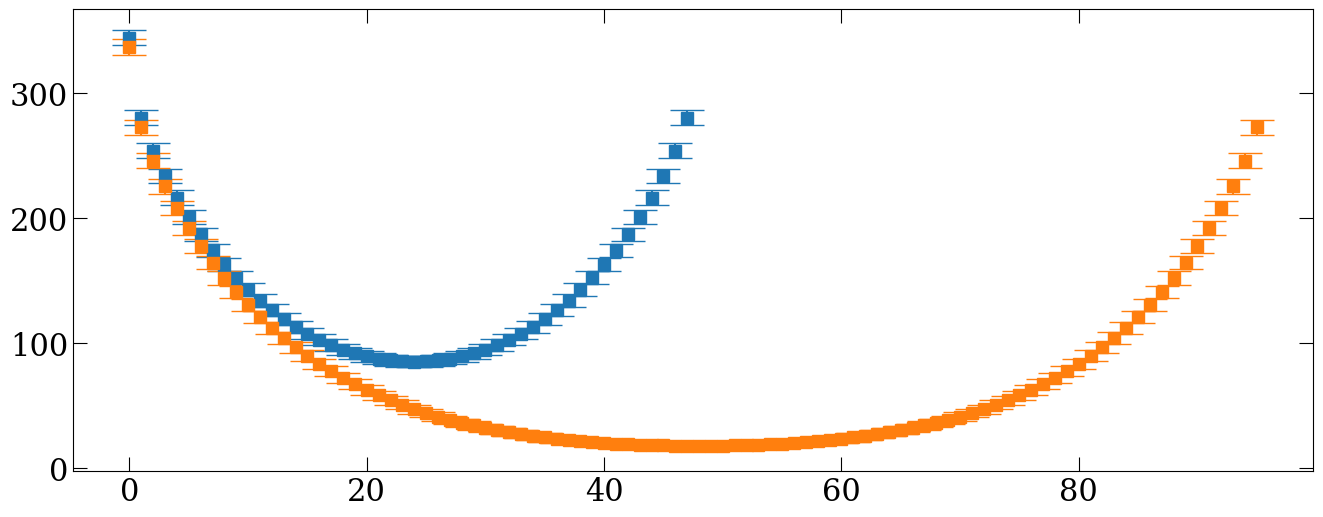

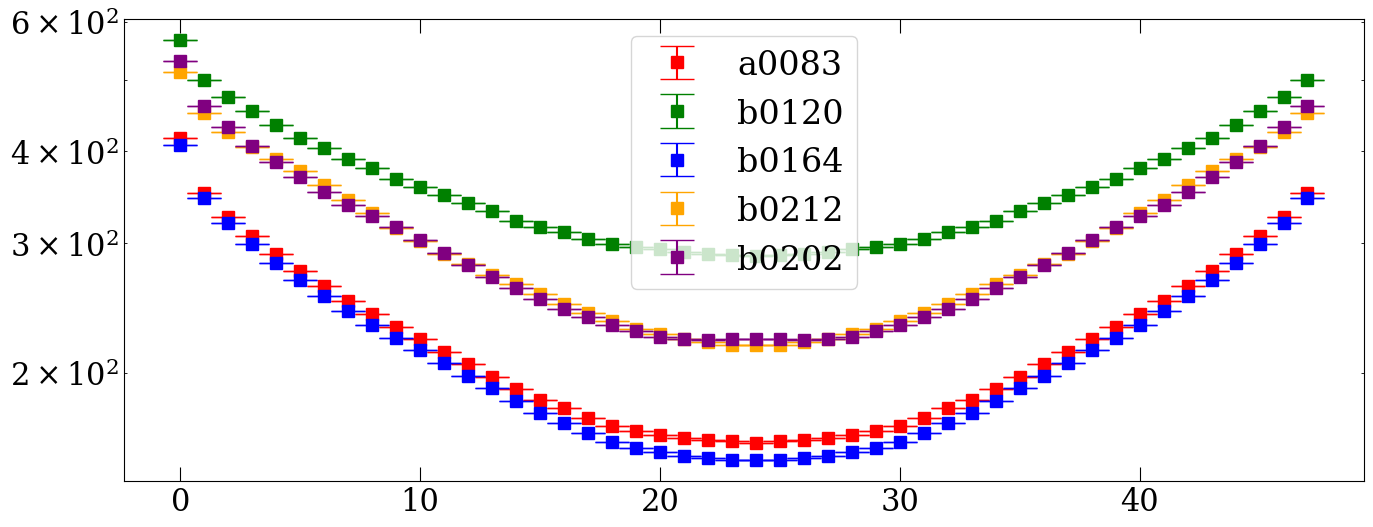

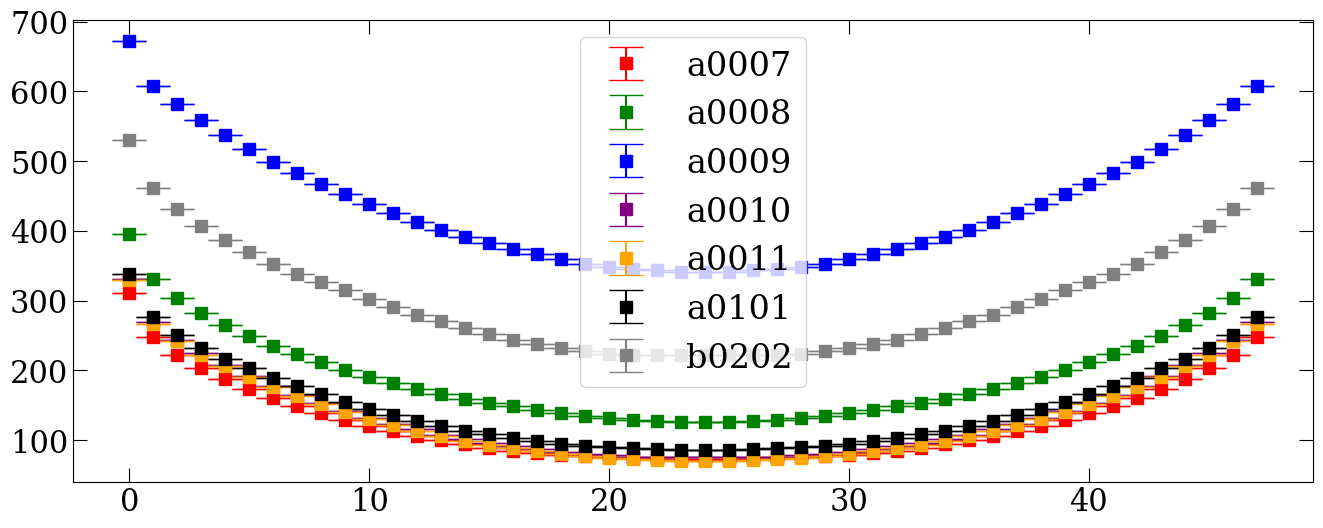

In [12]:
a=0.1163
hbarc = 1/197.3
aInv=1/(a*hbarc)

d_jk=1

fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
ax=axs[0,0]
xunit=1; yunit=1
for ky in ['a','hybrid']:
    c2pt=yu.jackknife(np.real(data[ky])[120:],d=d_jk)
    mean,err=yu.jackme(c2pt)
    
    plt_x=np.arange(len(mean))*xunit; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err)
    
fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
ax=axs[0,0]
xunit=1; yunit=1
for ind,color in zip([82,119,163,209,200],['r','g','b','orange','purple']):
# for ind,color in zip([209,209,209,209,209],['r','g','b','orange','purple']):
    for ky in ['a','hybrid'][:1]:
        c2pt=np.real(data[ky])[ind]
        
        plt_x=np.arange(len(c2pt))*xunit; plt_y=c2pt*yunit; plt_err=c2pt*yunit*0
        ax.errorbar(plt_x,plt_y,plt_err,color=color,label=cfgs[ind] if ky=='a' else None)
ax.set_yscale('log')
ax.legend()

fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
ax=axs[0,0]
xunit=1; yunit=1
for ind,color in zip([6,7,8,9,10,100,200],['r','g','b','purple','orange','black','grey']):
    for ky in ['a','hybrid'][:1]:
        c2pt=np.real(data[ky])[ind]
        
        plt_x=np.arange(len(c2pt))*xunit; plt_y=c2pt*yunit; plt_err=c2pt*yunit*0
        ax.errorbar(plt_x,plt_y,plt_err,color=color,label=cfgs[ind] if ky=='a' else None)
ax.legend()
    
# tau=1
# def C2pt2meff(C2pt,totalT):
#     tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
#     t=C2pt # dim=time
#     t=(np.roll(t,-tau,axis=0))/(t)
#     t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
#     return t
    
# fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)
# ax=axs[0,0]
# xunit=1; yunit=aInv
# ax.set_ylim([0,300])
# for ky in ['a','hybrid']:
#     c2pt=yu.jackknife(np.real(data[ky]),d=d_jk)
#     if ky=='a':
#         func=lambda c2pt:C2pt2meff(c2pt,48)
#     else:
#         func=lambda c2pt:C2pt2meff(c2pt,96)
#     meff=yu.jackmap(func,c2pt)
#     mean,err=yu.jackme(meff)
    
#     plt_x=np.arange(len(mean))*xunit; plt_y=mean*yunit; plt_err=err*yunit
#     ax.errorbar(plt_x,plt_y,plt_err)
    